In [1]:
import os
from rdkit import Chem

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS


## Read Data:


In [2]:
data = (
"1 _O6T 1,2-dimethoxybenzene COc1ccccc1OC -5.33 0.1 10.1007/s10822-014-9738-y",
"2 _O70 (2R,5R)-2-methyl-5-prop-1-en-2-ylcyclohexan-1-one C=C(C)[C@@H]1CC[C@@H](C)C(=O)C1  -2.53 0.25 10.1007/s10822-014-9738-y",
"3 _O71 (1S,5R)-2-methyl-5-prop-1-en-2-ylcyclohex-2-en-1-ol C=C(C)[C@@H]1CC=C(C)[C@@H](O)C1 -3.20 0.28 10.1007/s10822-014-9738-y",
"4 _P8I cyclopentanone O=C1CCCC1 -4.70, 0.60 10.1021/ct050097l",
"5 6J29 1-amino-4-hydroxyanthracene-9,10-dione Nc1ccc(O)c2c1C(=O)c1ccccc1C2=O -9.5 0.29 10.1007/s10822-014-9738-y",
"6 6KET 3-methoxyphenol COc1cccc(O)c1 -7.66 0.6 10.1021/ct050097l",
"7 8018 (1R,2S,3R,4R,6S,7S)-1,3,4,7,8,9,10,10-octachlorotricyclo[5.2.1.02,6]dec-8-ene ClC1=C(Cl)[C@]2(Cl)[C@H]3C[C@@H](Cl)[C@H](Cl)[C@H]3[C@@]1(Cl)C2(Cl)Cl -3.44 0.1 10.1021/jp806724u",
"8 E1VB [1,2,2-Trifluoroethoxy]benzene FC(F)[C@@H](F)Oc1ccccc1 -1.29 0.6 10.1007/s10822-014-9747-x",
"9 F313 4-methoxyaniline COc1ccc(N)cc1 -7.48  0.60 	10.1021/ct050097",
"10 G078 1,4-dimethylnaphthalene Cc1ccc(C)c2ccccc12 -2.82 0.60 10.1007/bf00646936 ",
"11 G277 cyclohexa-2,5-diene-1,4-dione O=C1C=CC(=O)C=C1 -5.78 0.19 10.1021/ja00236a026",
"12 M030 1,3,5-trimethylbenzene Cc1cc(C)cc(C)c1 -1.21 0.60 10.1021/ct050097l",
"13 M097 2-chloroaniline Nc1ccccc1Cl -4.91 0.60 10.1021/ct050097l",
"14 M218 N-methylaniline CNc1ccccc1  -4.69 0.60 10.1021/ct050097l",
"15 S002 Benzylbromide BrCc1ccccc1 -2.38 0.20 10.1021/jm070549+",
"16 TVVS pyridine-4-carbaldehyde O=Cc1ccncc1 -7.00 0.60 10.1021/ct050097l ",)

mols_dict = {}
field_data = list(map(lambda x: x.split(), data))
for id, name, iupac, csmile, dg, err, mdoi in field_data:
    mols_dict["lig_"+str(id)] = {"id": id, 
                                 "name":name, 
                                 "iupac": iupac, 
                                 "smiles":csmile,
                                 "doi": "10.1007/s10822-022-00445-6",
                                 "measurement":{
                                     "doi": mdoi,
                                    "error": err,
                                    "type":"hydration FE",
                                    "unit":"kcal/mol",
                                    "value":dg,
                                    "comment":"",
                                 },
                                 "mol": Chem.MolFromSmiles(csmile)}

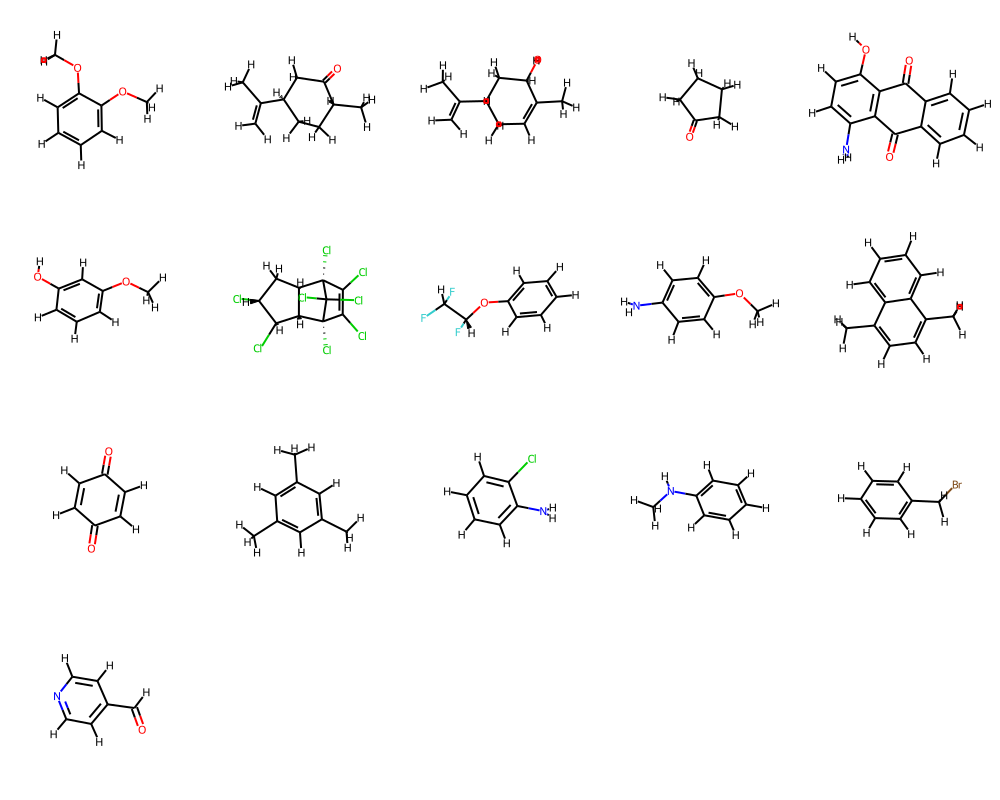

In [17]:
mols = {m:mols_dict[m]['mol'] for m in mols_dict}
cmols = {m:Chem.Mol(mols[m]) for m in mols}
cmols = {m:Chem.AddHs(cmols[m]) for m in cmols}
[Chem.rdDistGeom.EmbedMolecule(cmols[m]) for m in cmols]

for mol in cmols:
    new_smile = Chem.CanonSmiles(Chem.MolToSmiles(cmols[mol]))
    mols_dict[mol].update({"smiles": new_smile})
    
Chem.Draw.MolsToGridImage(cmols.values(), molsPerRow=5)

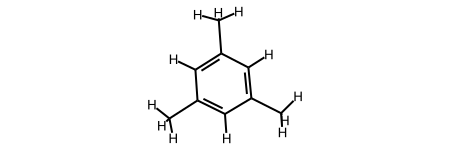

In [18]:
cmols["lig_12"]

In [19]:

def align_mols_mcs_all(mols, align_to=0):

    ##Load mols
    ##Align with mcs
    for mol2ID, mol_name in enumerate(mols):
        if(mol2ID==align_to):
            continue
        
        ref = mols[align_to]
        mv = mols[mol_name]
        mcs = rdFMCS.FindMCS([ref, mv], ringMatchesRingOnly=True, atomCompare=rdFMCS.AtomCompare.CompareAny)

        smart = mcs.smartsString #"[#6&R]1-&@[#6&R](-&!@[#1&!R])-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]" #mcs.smartsString
        patt = Chem.MolFromSmarts(smart)  # smartsString
        print("patternMol: ", mcs.smartsString)
        refMatch = ref.GetSubstructMatch(patt)
        print("refMatch:\t", refMatch)
        mvMatch = mv.GetSubstructMatch(patt)
        print("mvMatch:\t", mvMatch)

        try:
            AllChem.AlignMol(mv, ref, atomMap=list(zip(mvMatch, refMatch)),reflect=True)
        except Exception as err:
            raise err

    return mols

In [20]:
aligned_mols = align_mols_mcs_all(cmols, align_to="lig_12")


patternMol:  [#6,#1;!R]-&!@[#8,#6;!R]-&!@[#6&R]1:&@[#6&R](:&@[#6&R](:&@[#6&R](:&@[#6&R](:&@[#6&R]:&@1-&!@[#8,#1;!R])-&!@[#1,#6;!R])-&!@[#1&!R])-&!@[#1,#6;!R])-&!@[#1&!R]
refMatch:	 (9, 0, 1, 2, 3, 5, 6, 8, 20, 7, 16, 4, 12)
mvMatch:	 (0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 15, 14, 13)
patternMol:  [#6&!R](-&!@[#6&R]1:,-;@[#6&R]:,-;@[#6&R](-&!@[#6,#1;!R]):,-;@[#6&R](:,-;@[#6&R](:,-;@[#6&R]:,-;@1-&!@[#1&!R])-&!@[#6,#1;!R])-&!@[#1,#6;!R])(-&!@[#1&!R])(-&!@[#1&!R])-&!@[#1&!R]
refMatch:	 (0, 1, 2, 3, 4, 5, 6, 8, 20, 7, 16, 9, 10, 11)
mvMatch:	 (7, 6, 8, 10, 25, 3, 4, 5, 19, 17, 1, 22, 23, 24)
patternMol:  [#6&!R](-&!@[#6&R]:,-;@[#6&R](:,-;@[#6&R](:,-;@[#6&R](:,-;@[#6&R](:,-;@[#6&R]-&!@[#1&!R])-&!@[#6,#1;!R])-&!@[#1,#6;!R])-&!@[#6,#1;!R])-&!@[#1,#8;!R])(-&!@[#1&!R])(-&!@[#1&!R])-&!@[#1&!R]
refMatch:	 (0, 1, 2, 3, 5, 6, 8, 20, 7, 16, 4, 12, 9, 10, 11)
mvMatch:	 (7, 6, 8, 10, 3, 4, 5, 19, 17, 1, 25, 9, 20, 21, 22)
patternMol:  [#6&R](-,:;@[#6&R](-,:;@[#6&R](-,:;@[#6&R]-&!@[#1&!R])-&!@[#1,#6;!R])-&!@[#

In [21]:
import nglview as ng

first = True
show_mols  =[aligned_mols["lig_12"], aligned_mols["lig_1"]] # aligned_mols.values() #
for mol in show_mols:
    if(first):
        first = False
        view = ng.show_rdkit(mol)
    else:
        view.add_component(mol)
        
view

NGLWidget()

In [26]:
out_sdf = Chem.SDWriter(open("RHFE_benzenes.sdf", "w"))
for mol in aligned_mols:
    m = aligned_mols[mol]
    m.SetProp("_Name", mols_dict[mol]['name'])     
    [m.SetProp(str(k), str(v)) for k,v in mols_dict[mol].items() if(k!="mol")]
    m.SetProp("key", mol)
    out_sdf.write(m)
    
out_sdf.close()

In [28]:
Chem.MolToSmiles(m)

'[H]C(=O)c1c([H])c([H])nc([H])c1[H]'

In [24]:
import yaml

clean_mols_dict = {}
for mol, mol_dict in mols_dict.items():
    clean_mols_dict[mol] = {key:val for key, val in mol_dict.items() if(key!="mol")}
                            
with open("RHFE_benzenes.yml", "w") as file:
    yaml.dump(clean_mols_dict, file)